In [29]:
# Imports

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd


In [30]:
# Audio files are stored in the following directory:
# data/data_final/audios/Contr
# data/data_final/audios/FESS
# data/data_final/audios/Sept
# data/data_final/audios/Tonsill

# Get all .wav audios from all the directories
path_to_audios = 'data/data_final/audios'
audios = []
for root, dirs, files in os.walk(path_to_audios):
    for name in files:
        if name.endswith('.wav'):
            audios.append(os.path.join(root, name))


In [31]:
# The following code will load the audio files:
def read_audio(path):
    y, sr = librosa.load(path, sr=44100)
    return y, sr

df = pd.DataFrame(columns=['audiopath','audio_raw','label'])
df['audiopath'] = audios
# Get SR and audio in two columns
df[['audio_raw', 'sr']] = df['audiopath'].apply(lambda x: pd.Series(read_audio(x)))
df['label'] = df['audiopath'].apply(lambda x: x.split('/')[3])

In [32]:
# Normalise the audios

def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

df['audio'] = df['audio_raw'].apply(lambda x: normalize_audio(x))

In [33]:
# Get a new column with the session number extracted from the audio path
df['session'] = df['audiopath'].apply(lambda x: x.split('/')[5])

In [34]:
# Drop all rows which have session aeiou, or concatenateread or tests
df = df[~df['session'].isin(['aeiou', 'concatenateread', 'tests'])]

In [35]:
# Calculate mfccs
def extract_mfcc_with_derivatives(
       audio, sample_rate, frame_length_ms, n_mfcc=10
    ):
        """
        Extracts Mel-frequency cepstral coefficients (MFCCs) with their first and second derivatives from an audio signal.

        Args:
            audio (np.ndarray): The audio signal as a 1D numpy array.
            sample_rate (int): The sample rate of the audio signal.
            frame_length_ms (float): The length of the frames in milliseconds.
            n_mfcc (int): The number of MFCCs to extract.

        Returns:
            np.ndarray: A 2D numpy array of shape (num_frames, num_features) containing the MFCCs and their derivatives.
        """
        frame_length = int(
            sample_rate * frame_length_ms * 1e-3
        )  # Convert ms to samples
        hop_length = int(frame_length / 2)  # 50% overlap
        frames = librosa.util.frame(
            audio, frame_length=frame_length, hop_length=hop_length
        )

        # Apply hanning windows
        frames = frames * np.hanning(frame_length)[:, None]

        # N_fft is the next number in power of 2 of the frame size
        n_fft = 2 ** (int(np.log2(frames.shape[1])) + 1)

        # Compute MFCC for each frame
        mfccs = []
        for frame in frames.T:
            mfcc = librosa.feature.mfcc(
                y=frame, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft
            )
            # Normalize the MFCCs
            mfccs.append(mfcc.T)

        mfccs = np.vstack(mfccs)

        # Normalize the MFCCs
        mfccs = (mfccs - np.mean(mfccs, axis=0)) / np.std(mfccs, axis=0)

        # Compute derivatives
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        # Concatenate the features
        mfcc_features = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=1)

        return mfcc_features

## COMPUTING MFCCS

Care, this requires time to compute. It took 11 min and 10.5 secs to compute in a computer with the following specs:

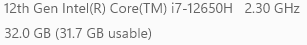

In [40]:
# Select only the first session
df_first_session = df[df['session'] == '1']

# Calculate the MFCCs for the first session
df_first_session["mfccs"] = df_first_session.apply(
                lambda x: extract_mfcc_with_derivatives(
                    x["audio"],
                    x["sr"],
                    40,
                    13,
                ),
                axis=1,
            )

/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=4096 is too large for input signal of length=1764
  warnings.warn(
/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(
/tmp/ipykernel_767/1647392553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_

In [48]:
# Explode the mfccs column
df_first_session = df_first_session.explode('mfccs')


In [49]:
df_first_session

,audiopath,audio_raw,label,sr,audio,session,mfccs
188,data/data_final/audios/fess/a1/1/Cens_ses1_a1_...,"[0.007843018, 0.0079956055, 0.006011963, 0.004...",fess,44100,"[0.039016243, 0.039775316, 0.029907394, 0.0229...",1,"[-1.3873022307195646, 0.3625809969356039, 1.26..."
188,data/data_final/audios/fess/a1/1/Cens_ses1_a1_...,"[0.007843018, 0.0079956055, 0.006011963, 0.004...",fess,44100,"[0.039016243, 0.039775316, 0.029907394, 0.0229...",1,"[0.4984080324676768, -1.4367795794907738, -1.4..."
188,data/data_final/audios/fess/a1/1/Cens_ses1_a1_...,"[0.007843018, 0.0079956055, 0.006011963, 0.004...",fess,44100,"[0.039016243, 0.039775316, 0.029907394, 0.0229...",1,"[1.1626912457385703, -1.9145325567929363, -0.7..."
188,data/data_final/audios/fess/a1/1/Cens_ses1_a1_...,"[0.007843018, 0.0079956055, 0.006011963, 0.004...",fess,44100,"[0.039016243, 0.039775316, 0.029907394, 0.0229...",1,"[-0.5930672160512358, 1.2830012644437674, 0.81..."
188,data/data_final/audios/fess/a1/1/Cens_ses1_a1_...,"[0.007843018, 0.0079956055, 0.006011963, 0.004...",fess,44100,"[0.039016243, 0.039775316, 0.029907394, 0.0229...",1,"[0.1756992542014915, -0.4399979646318356, 0.61..."
...,...,...,...,...,...,...,...
4696,data/data_final/audios/septo/brasero/1/Sept_se...,"[0.00036621094, 0.00012207031, -0.00021362305,...",septo,44100,"[0.0020678958, 0.0006892986, -0.0012062726, -0...",1,"[-0.6595519609962168, 0.7371940203666035, 0.48..."
4696,data/data_final/audios/septo/brasero/1/Sept_se...,"[0.00036621094, 0.00012207031, -0.00021362305,...",septo,44100,"[0.0020678958, 0.0006892986, -0.0012062726, -0...",1,"[-1.7225856162936481, 0.5859073776442701, 1.59..."
4696,data/data_final/audios/septo/brasero/1/Sept_se...,"[0.00036621094, 0.00012207031, -0.00021362305,...",septo,44100,"[0.0020678958, 0.0006892986, -0.0012062726, -0...",1,"[-0.237760887935658, -0.3238344283040434, 0.43..."
4696,data/data_final/audios/septo/brasero/1/Sept_se...,"[0.00036621094, 0.00012207031, -0.00021362305,...",septo,44100,"[0.0020678958, 0.0006892986, -0.0012062726, -0...",1,"[-0.13617099069277824, -0.4622660232479788, 0...."


## Simple classifier

Let us generate a toy example where we want to distinguish control vs patients.

In [70]:
# First, get only the interesting columns: "mfccs", "label" and the index with is the id
df_toy = df_first_session[["mfccs", "label"]].reset_index()

In [71]:
# Index column is the patient identification, hence, split into train and test based on this column so the same patient is not in both
df_train = df_toy[df_toy["index"] % 2 == 0]
df_test = df_toy[df_toy["index"] % 2 == 1]

In [72]:
# Binarise the labels, "control" is 0 and all the othres are 1
df_train["label"] = df_train["label"].apply(lambda x: 0 if x == "control" else 1)
df_test["label"] = df_test["label"].apply(lambda x: 0 if x == "control" else 1)


/tmp/ipykernel_767/278746171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = df_train["label"].apply(lambda x: 0 if x == "control" else 1)
/tmp/ipykernel_767/278746171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = df_test["label"].apply(lambda x: 0 if x == "control" else 1)


In [74]:
# Print value counts for each label
print(df_train["label"].value_counts())

label
1    456996
0    218984
Name: count, dtype: int64


In [75]:
# Train a RandomForest model
from sklearn.ensemble import RandomForestClassifier

X_train = np.vstack(df_train["mfccs"].values)
y_train = df_train["label"].values

X_test = np.vstack(df_test["mfccs"].values)
y_test = df_test["label"].values

print("Training...")

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

print("Predicting...")

# Get the predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)



Training...
Predicting...


In [76]:
# Get the accuracy
from sklearn.metrics import accuracy_score
# print training accuracy
print("Training accuracy: ", accuracy_score(y_train, y_pred_train))
# print test accuracy
print("Test accuracy: ", accuracy_score(y_test, y_pred_test))

Training accuracy:  0.6935086836888665
Test accuracy:  0.6698430618899809


# KALMAN trajectories

The file .mat containes the information needed to calculate the KALMAN trajectories and the trajectories themselves.

In [5]:
# Read a mat file
import os
import scipy.io

def load_mat_file(mat_file_path):
    # Load the MATLAB file
    mat_data = scipy.io.loadmat(mat_file_path)

    # Extract the 'data' dictionary from the loaded MATLAB file
    data = mat_data['data'][0, 0]

    # Create a Python dictionary from the MATLAB 'data' dictionary
    result_dict = {
        'params': data['params'][0],
        'x': data['x'],
        'x_est': data['x_est'],  # f1, f2, f3, antif1, antif2 media de todos ellos
        'x_errVar': data['x_errVar'] # 
    }

    return result_dict

# Load all .mat files under data/data_final/audios
path_to_mat_files = 'data/data_final/audios'
mat_files = []
for root, dirs, files in os.walk(path_to_mat_files):
    for name in files:
        if name.endswith('.mat'):
            mat_files.append(os.path.join(root, name))

# Get the data from the mat files
mat_data = []
for mat_file in mat_files:
    mat_data.append(load_mat_file(mat_file))


# Modify result_dict to a more easy to use format





In [100]:
# Each mat_file['x_errVar'].shape is (10, 10, 715). The 10 are: 3 formants, 2 antiformants, 5 BWs. The 715 are the number of frames

# split each matrix into a dictionary with the formants, antiformants and BWs as keys
var_for_each_file = []
for mat_file in mat_data:
    x_errVar_dict = {}
    x_errVar_dict["Formants"] = mat_file['x_errVar'][:3, :3] # Convariance matrix
    x_errVar_dict["AntiFormants"] = mat_file['x_errVar'][3:5, 3:5,] # Convariance matrix
    x_errVar_dict["BWs"] = mat_file['x_errVar'][5:, 5:, :] # Convariance matrix
    var_for_each_file.append(x_errVar_dict)

In [107]:
# Each mat_file["x_est"].shape is (10, 715). There are: 3 formants, 2 antiformants, 5 BWs. The 715 are the number of frames

# split each matrix into a dictionary with the formants, antiformants and BWs as keys
est_for_each_file = []
for mat_file in mat_data:
    x_est_dict = {}
    x_est_dict["Formants"] = mat_file['x_est'][:3, :] # Convariance matrix
    x_est_dict["AntiFormants"] = mat_file['x_est'][3:5, :] # Convariance matrix
    x_est_dict["BWs"] = mat_file['x_est'][5:, :] # Convariance matrix
    est_for_each_file.append(x_est_dict)

In [111]:
# Generate a final dictionary where for each mat_file. This dictionary have 3 keys:
# 1. "input": is mat_file["x"] which is a 20212,1 audio signal
# 2. "output_mean": is each element of x_est_dict["Formants"], x_est_dict["AntiFormants"] and x_est_dict["BWs"]
# 3. "output_covar": is each element of x_errVar_dict["Formants"], x_errVar_dict["AntiFormants"] and x_errVar_dict["BWs"]

final_dict = []
for i in range(len(mat_data)):
    final_dict.append({"input": mat_data[i]["x"], "output_mean": est_for_each_file[i], "output_covar": var_for_each_file[i]})

In [117]:
# subtitute each .mat file with the final dictionary in pkl format
import pickle
for i in range(len(mat_files)):
    with open(mat_files[i].replace(".mat", ".pkl"), 'wb') as f:
        pickle.dump(final_dict[i], f)

In [6]:
# Read one pickle file and explain the structure
import pickle
with open(mat_files[1].replace(".mat", ".pkl"), 'rb') as f:
    data = pickle.load(f)

# data is a dictionary with 3 keys: "input", "output_mean" and "output_covar"
# "input" is a 20212,1 audio signal
# "output_mean" is a dictionary with 3 keys: "Formants", "AntiFormants" and "BWs"
# "output_covar" is a dictionary with 3 keys: "Formants", "AntiFormants" and "BWs"
# For output_mean and output_covar, each key is a matrix with the following shape:
# "Formants" is a 3, 715 matrix
# "AntiFormants" is a 2, 2, 715 matrix
# "BWs" is a 5, 715 matrix (corresponding the 3 formants and 2 antiformants)

data["output_mean"]["AntiFormants"].shape


(2, 1241)

In [7]:
# Remove all .mat files
import os
for mat_file in mat_files:
    os.remove(mat_file)